## I. Import et découverte du fichier 

In [1]:
import os
os.chdir("C:/Fouille-donnees-massives")

In [2]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [3]:
#pip install fastparquet

In [4]:
import fastparquet

Nous importons le fichier sans une ligne qui ne permet pas de lire correctement les données.

In [5]:
df=pd.read_table("guillaume.txt", sep=";",header=0, decimal=",",skiprows=[1956361])

In [6]:
df.head()

,ZIBZIN,IDAvisAutorisationCheque,FlagImpaye,Montant,DateTransaction,CodeDecision,VerifianceCPT1,VerifianceCPT2,VerifianceCPT3,D2CB,...,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,Heure
0,A013010004908126703060931,78643044,0,20.00,2017-02-01 07:32:14,1,0,0,0,551,...,37.186668,52.076034,0,1,4.000000,4.0,4.0,20.00,0.00,27134
1,A013011306908024927155000,78643045,0,20.00,2017-02-01 07:43:37,1,0,0,0,551,...,48.844716,52.076034,1,2,1.797685,4.0,4.0,28.61,8.61,27817
2,A013010002908283134592527,78643046,0,57.64,2017-02-01 07:47:38,1,0,0,0,549,...,73.118280,52.076034,0,1,4.000000,4.0,4.0,57.64,0.00,28058
3,A011010002908105209831316,78643047,0,54.29,2017-02-01 07:48:48,0,1,1,1,267,...,110.056926,53.554234,0,1,4.000000,4.0,4.0,54.29,0.00,28128
4,A013010041908000125652029,78643048,0,26.90,2017-02-01 08:13:27,1,0,0,0,549,...,45.368313,52.076034,1,1,1.997106,4.0,4.0,59.15,32.25,29607


In [7]:
print("le fichier contient " + str(df.shape[0]) + " lignes et " +str(df.shape[1])+ " colonnes.")
taille=sys.getsizeof(df)
print("taille (octets) = "+str(taille))
print("taille (bits) = "+str(taille/8))

le fichier contient 4646773 lignes et 23 colonnes.
taille (octets) = 1514848142
taille (bits) = 189356017.75


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4646773 entries, 0 to 4646772
Data columns (total 23 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   ZIBZIN                    object 
 1   IDAvisAutorisationCheque  int64  
 2   FlagImpaye                int64  
 3   Montant                   float64
 4   DateTransaction           object 
 5   CodeDecision              int64  
 6   VerifianceCPT1            int64  
 7   VerifianceCPT2            int64  
 8   VerifianceCPT3            int64  
 9   D2CB                      int64  
 10  ScoringFP1                float64
 11  ScoringFP2                float64
 12  ScoringFP3                float64
 13  TauxImpNb_RB              float64
 14  TauxImpNB_CPM             float64
 15  EcartNumCheq              int64  
 16  NbrMagasin3J              int64  
 17  DiffDateTr1               float64
 18  DiffDateTr2               float64
 19  DiffDateTr3               float64
 20  CA3TRetMtt              

## II. Nettoyage du fichier

 **1. Variable "CodeDecision"** 

A utiliser uniquement en phase d'apprentissage : elle possède une valeur à 4 alors que dans la description des données, cette variable ne peut prendre que les valeurs {0,1,2,3}. 
Nous retirons cette valeur "4".

In [9]:
print("Dans le fichier initial :")
print(df['CodeDecision'].value_counts())
df=df.drop(df[df["CodeDecision"]==4].index, axis= 0)

print("Supression de la ligne :")
print(df['CodeDecision'].value_counts())

Dans le fichier initial :
0    3502786
1    1121626
2      19562
3       2798
4          1
Name: CodeDecision, dtype: int64
Supression de la ligne :
0    3502786
1    1121626
2      19562
3       2798
Name: CodeDecision, dtype: int64


**2. Variable "Heure"** 

Cette variable fait doublon avec "DateTransaction". Nous la supprimons. 

In [10]:
df.drop(['Heure'], axis = "columns", inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4646772 entries, 0 to 4646772
Data columns (total 22 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   ZIBZIN                    object 
 1   IDAvisAutorisationCheque  int64  
 2   FlagImpaye                int64  
 3   Montant                   float64
 4   DateTransaction           object 
 5   CodeDecision              int64  
 6   VerifianceCPT1            int64  
 7   VerifianceCPT2            int64  
 8   VerifianceCPT3            int64  
 9   D2CB                      int64  
 10  ScoringFP1                float64
 11  ScoringFP2                float64
 12  ScoringFP3                float64
 13  TauxImpNb_RB              float64
 14  TauxImpNB_CPM             float64
 15  EcartNumCheq              int64  
 16  NbrMagasin3J              int64  
 17  DiffDateTr1               float64
 18  DiffDateTr2               float64
 19  DiffDateTr3               float64
 20  CA3TRetMtt              

**3. Variable "DateTransaction"**

Nous séparons la date et l'heure dans 2 colonnes distinctes. 

In [11]:
DateTransaction_1=df["DateTransaction"].str.split(' ',1)
df['Date']=DateTransaction_1.str[0]
df['Heure']=DateTransaction_1.str[1]
df.drop(['DateTransaction'], axis='columns', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4646772 entries, 0 to 4646772
Data columns (total 23 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   ZIBZIN                    object 
 1   IDAvisAutorisationCheque  int64  
 2   FlagImpaye                int64  
 3   Montant                   float64
 4   CodeDecision              int64  
 5   VerifianceCPT1            int64  
 6   VerifianceCPT2            int64  
 7   VerifianceCPT3            int64  
 8   D2CB                      int64  
 9   ScoringFP1                float64
 10  ScoringFP2                float64
 11  ScoringFP3                float64
 12  TauxImpNb_RB              float64
 13  TauxImpNB_CPM             float64
 14  EcartNumCheq              int64  
 15  NbrMagasin3J              int64  
 16  DiffDateTr1               float64
 17  DiffDateTr2               float64
 18  DiffDateTr3               float64
 19  CA3TRetMtt                float64
 20  CA3TR                   

**4. Conservation des variables utiles**

Afin de réduire le dataset au nombre de variables pertinentes, nous souhaitons éliminer les variables redondantes en analysant les corrélations entre variables et en particulier, avec la variable à expliquer (FlagImpaye).

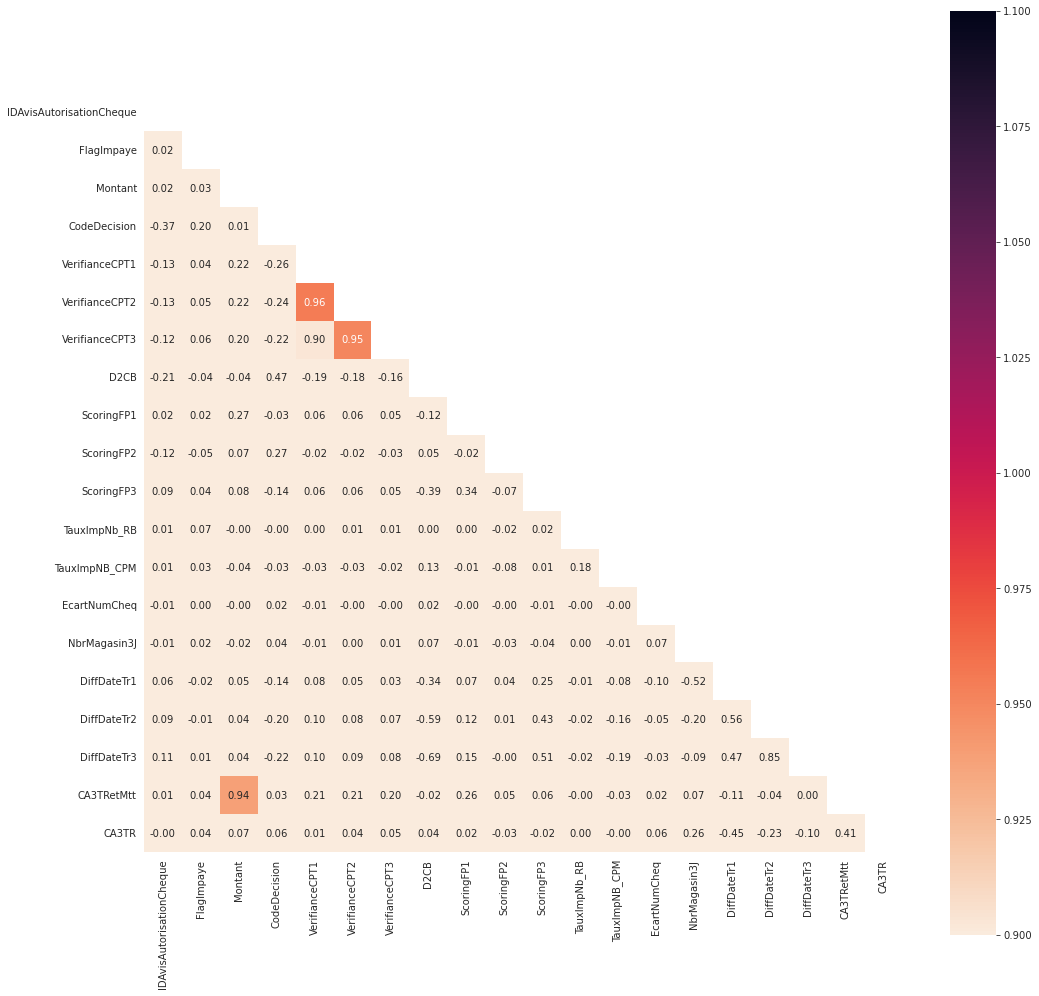

In [12]:
#Matrice de corrélation

corr=df.corr()

gauche=np.zeros_like(corr)
gauche[np.triu_indices_from(gauche)] = True

#matrice
with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(17,17))
        ax=sns.heatmap(corr,mask=gauche, square=True, annot=True, fmt= '.2f', cmap= "rocket_r", vmin=1, vmax=1)


**Que nous apprend cette matrice ?**

(1) Les variables VerifianceCPT1/ ...CPT2/... CPT3 sont visiblement redondantes entre elles : une seule suffit, nous conservons la variable CPT1 (nombre de transactions jour par le même ID)

(2) Le montant et CATRetMtt sont logiquement très corélées, la dernière étant notamment basée notamment sur le montant : nous la supprimons

(3) les 3 DiffDateTr sont aussi corrélées, partiellement redondantes, nous supprimons "...Tr2 et "...Tr3", et conservons "...Tr1" (écart en jours à partir de la dernière transaction)


**Suppression complémentaire de variables sans intérêt pour la modélisation**

(1) les différents ID : ZIBZIN, IDAvisAutorisationCheque

(2) Code décision : nous ne pouvons pas nous en servir pour la prédiction puisqu'elle est renseignée après la fraude

(3)TauxImpNb_RB : dans l'absolu, il aurait été intéressant de l'étudier mais il n'y pas de variables géographiques pour pouvoir la croiser (ex : regarder les différences Nord / Sud). 

In [13]:
#En synthèse, suppression de 10 variables ; conservation de 13 variables
df.drop(['ZIBZIN', 'IDAvisAutorisationCheque', 'CodeDecision','VerifianceCPT2','VerifianceCPT3','TauxImpNb_RB','DiffDateTr1','DiffDateTr2','CA3TRetMtt'], axis='columns', inplace=True)
df.head()

,FlagImpaye,Montant,VerifianceCPT1,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr3,CA3TR,Date,Heure
0,0,20.00,0,551,0.000000,0.000000,0.000000,52.076034,0,1,4.0,0.00,2017-02-01,07:32:14
1,0,20.00,0,551,0.000000,0.000000,0.000000,52.076034,1,2,4.0,8.61,2017-02-01,07:43:37
2,0,57.64,0,549,0.000000,0.000000,0.000000,52.076034,0,1,4.0,0.00,2017-02-01,07:47:38
3,0,54.29,1,267,0.000000,0.000000,0.000000,53.554234,0,1,4.0,0.00,2017-02-01,07:48:48
4,0,26.90,0,549,0.003769,8.586333,0.001192,52.076034,1,1,4.0,32.25,2017-02-01,08:13:27


## III. Création des échantillons d'entraînement et de test

In [14]:
#Création du train and test selon les consignes données dans le cahier des charges
#les données test = données les plus récentes selon la méthodologie des séries temporelles
train=df.loc[df['Date']<='2017-08-31']
test=df.loc[df['Date']>='2017-09-01']

In [15]:
#Test : 747 410 enregistrements #16%
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 747410 entries, 3899362 to 4646772
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   FlagImpaye      747410 non-null  int64  
 1   Montant         747410 non-null  float64
 2   VerifianceCPT1  747410 non-null  int64  
 3   D2CB            747410 non-null  int64  
 4   ScoringFP1      747410 non-null  float64
 5   ScoringFP2      747410 non-null  float64
 6   ScoringFP3      747410 non-null  float64
 7   TauxImpNB_CPM   747410 non-null  float64
 8   EcartNumCheq    747410 non-null  int64  
 9   NbrMagasin3J    747410 non-null  int64  
 10  DiffDateTr3     747410 non-null  float64
 11  CA3TR           747410 non-null  float64
 12  Date            747410 non-null  object 
 13  Heure           747410 non-null  object 
dtypes: float64(7), int64(5), object(2)
memory usage: 85.5+ MB


In [16]:
#Train : 3 899 362 enregistrements #84%
train.shape[0]

3899362

En vue d'optimiser les traitements tels les centrages-réductions, nous retirons la date et l'heure ; nous avons déjà des informations temporelles conservées comme DiffDateTr1 pertinentes (écart en jours avec la précédente transaction).

In [17]:
# Supprimer les variables "Date" et "Heure"
train = train.drop(["Date", "Heure"], axis = "columns")
test = test.drop(["Date", "Heure"], axis = "columns")

En vue d'optimiser les temps de traitement pour la création des modèles, nous convertissons les dataframes au format Parquet (stockage orienté colonnes).

In [18]:
#Transformation en Dask du Train
train_d=dd.from_pandas(train,npartitions=20)
print(train_d.dtypes)

FlagImpaye          int64
Montant           float64
VerifianceCPT1      int64
D2CB                int64
ScoringFP1        float64
ScoringFP2        float64
ScoringFP3        float64
TauxImpNB_CPM     float64
EcartNumCheq        int64
NbrMagasin3J        int64
DiffDateTr3       float64
CA3TR             float64
dtype: object


In [19]:
#Transformation en Dask du Test
test_d=dd.from_pandas(test,npartitions=20)
print(test_d.dtypes)

FlagImpaye          int64
Montant           float64
VerifianceCPT1      int64
D2CB                int64
ScoringFP1        float64
ScoringFP2        float64
ScoringFP3        float64
TauxImpNB_CPM     float64
EcartNumCheq        int64
NbrMagasin3J        int64
DiffDateTr3       float64
CA3TR             float64
dtype: object


In [20]:
# Dask en parquet
#Train
train_d.to_parquet('train_fast')

(None,)

In [21]:
#Test
test_d.to_parquet('test_fast')

(None,)

## IV. Vérification des datasets au format Parquet

In [22]:
Train=dd.read_parquet('train_fast')
Train.head()

,FlagImpaye,Montant,VerifianceCPT1,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr3,CA3TR
0,0,20.00,0,551,0.000000,0.000000,0.000000,52.076034,0,1,4.0,0.00
1,0,20.00,0,551,0.000000,0.000000,0.000000,52.076034,1,2,4.0,8.61
2,0,57.64,0,549,0.000000,0.000000,0.000000,52.076034,0,1,4.0,0.00
3,0,54.29,1,267,0.000000,0.000000,0.000000,53.554234,0,1,4.0,0.00
4,0,26.90,0,549,0.003769,8.586333,0.001192,52.076034,1,1,4.0,32.25


In [23]:
Test=dd.read_parquet('test_fast')
Test.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 12 entries, FlagImpaye to CA3TR
dtypes: float64(7), int64(5)

## V.Recalibrage des données

Le taux de fraudes est de 0.6% dans l'échantillon d'apprentissage. Afin de pouvoir améliorer le taux de détection des fraudes en phase prédictive, une phase de recalibrage est à réaliser. 

**Nous réaliserons quelques benchmarks des méthodes de recalibrage.** 

In [56]:
#Quel est le taux de fraudes dans l'échantillon d'apprentissage ?
print(Train['FlagImpaye']. value_counts(normalize = True).compute())

0    0.993993
1    0.006007
Name: FlagImpaye, dtype: float64


In [58]:
#Quel est le nombre de fraudeurs dans l'échantillon d'apprentissage ?
print(Train['FlagImpaye']. value_counts(normalize = False).compute())

0    3875940
1      23422
Name: FlagImpaye, dtype: int64


In [25]:
#Véerification : quel est le taux de fraudes dans l'échantillon de test ?
print(Test['FlagImpaye']. value_counts(normalize = True).compute())

0    0.991206
1    0.008794
Name: FlagImpaye, dtype: float64


In [26]:
# Séparation de XTrain et yTrain 
XTrain = train_d.drop(["FlagImpaye"], axis = "columns")
yTrain = train_d["FlagImpaye"]

**(1) Recalibrage SMOTE simple pour aggrandir la classe positive (classe des fraudeurs, minoritaire) à 50%**

Principe : Les points de données de la classe minoritaire ('Flag_impayé' = 1), sont sur-échantillonnés en introduisant des exemples synthétiques le long des segments de droite joignant les k plus-proches voisins de la classe minoritaire (où k est un paramètre défini par l’utilisateur : nous le fixons à 3).

In [27]:
#pip install imblearn

In [28]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 0, k_neighbors=3) 

XTrain_SMOTE, yTrain_SMOTE = smote.fit_resample(XTrain, yTrain)

In [29]:
XTrain_SMOTE.head()

,Montant,VerifianceCPT1,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr3,CA3TR
0,20.00,0,551,0.000000,0.000000,0.000000,52.076034,0,1,4.0,0.00
1,20.00,0,551,0.000000,0.000000,0.000000,52.076034,1,2,4.0,8.61
2,57.64,0,549,0.000000,0.000000,0.000000,52.076034,0,1,4.0,0.00
3,54.29,1,267,0.000000,0.000000,0.000000,53.554234,0,1,4.0,0.00
4,26.90,0,549,0.003769,8.586333,0.001192,52.076034,1,1,4.0,32.25


In [30]:
print("Nombre d'exemples avec SMOTE - 3 plus proches voisins = " + str(XTrain_SMOTE.shape[0]))

Nombre d'exemples avec SMOTE - 3 plus proches voisins = 7751880


In [31]:
# Répartition fraudeurs / non fraudeurs
print(yTrain_SMOTE.value_counts(normalize = True))

0    0.5
1    0.5
Name: FlagImpaye, dtype: float64


In [32]:
train_SMOTE = XTrain_SMOTE
train_SMOTE["FlagImpaye"] = yTrain_SMOTE
train_SMOTE.head()

,Montant,VerifianceCPT1,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr3,CA3TR,FlagImpaye
0,20.00,0,551,0.000000,0.000000,0.000000,52.076034,0,1,4.0,0.00,0
1,20.00,0,551,0.000000,0.000000,0.000000,52.076034,1,2,4.0,8.61,0
2,57.64,0,549,0.000000,0.000000,0.000000,52.076034,0,1,4.0,0.00,0
3,54.29,1,267,0.000000,0.000000,0.000000,53.554234,0,1,4.0,0.00,0
4,26.90,0,549,0.003769,8.586333,0.001192,52.076034,1,1,4.0,32.25,0


In [33]:
#Conversion du dataframe suréchantillonné
train_SMOTE_d = dd.from_pandas(train_SMOTE, npartitions=20)
print(train_SMOTE_d)

Dask DataFrame Structure:
                Montant VerifianceCPT1   D2CB ScoringFP1 ScoringFP2 ScoringFP3 TauxImpNB_CPM EcartNumCheq NbrMagasin3J DiffDateTr3    CA3TR FlagImpaye
npartitions=20                                                                                                                                        
0               float64          int64  int64    float64    float64    float64       float64        int64        int64     float64  float64      int64
387594              ...            ...    ...        ...        ...        ...           ...          ...          ...         ...      ...        ...
...                 ...            ...    ...        ...        ...        ...           ...          ...          ...         ...      ...        ...
7364286             ...            ...    ...        ...        ...        ...           ...          ...          ...         ...      ...        ...
7751879             ...            ...    ...        ...        ... 

In [34]:
# Le dataframe propre d’apprentissage avec sur-échantillonnage : dfTrain_SMOTE_parquet
train_SMOTE_d.to_parquet('train_SMOTE')

(None,)

**(2) Recalibrage borderline SMOTE pour aggrandir la classe positive (classe des fraudeurs, minoritaire) à 50%, avec meilleure prise en compte des exemples borderline**

Principe : un deuxième paramètre, k’, fixé à 2, sert à déterminer les exemples borderline - c’est-à-dire les exemples dont la majorité des voisins appartiennent à la classe majoritaire.

In [35]:
#from imblearn.over_sampling import Bordeline SMOTE# ajout du paramètre : m_neighbors 

from imblearn.over_sampling import BorderlineSMOTE
sm = BorderlineSMOTE(random_state = 0, k_neighbors=3, m_neighbors=2,sampling_strategy ='minority') 

XTrain_borderS, yTrain_borderS = smote.fit_resample(XTrain, yTrain)

In [36]:
XTrain_borderS.head()

,Montant,VerifianceCPT1,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr3,CA3TR
0,20.00,0,551,0.000000,0.000000,0.000000,52.076034,0,1,4.0,0.00
1,20.00,0,551,0.000000,0.000000,0.000000,52.076034,1,2,4.0,8.61
2,57.64,0,549,0.000000,0.000000,0.000000,52.076034,0,1,4.0,0.00
3,54.29,1,267,0.000000,0.000000,0.000000,53.554234,0,1,4.0,0.00
4,26.90,0,549,0.003769,8.586333,0.001192,52.076034,1,1,4.0,32.25


In [37]:
print("Nombre d'exemples avec borderline SMOTE = " + str(XTrain_borderS.shape[0]))

Nombre d'exemples avec borderline SMOTE = 7751880


In [38]:
# Répartition fraudeurs / non fraudeurs
print(yTrain_borderS.value_counts(normalize = True))

0    0.5
1    0.5
Name: FlagImpaye, dtype: float64


In [39]:
train_borderS= XTrain_borderS
train_borderS["FlagImpaye"] = yTrain_borderS
train_borderS.head()

,Montant,VerifianceCPT1,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr3,CA3TR,FlagImpaye
0,20.00,0,551,0.000000,0.000000,0.000000,52.076034,0,1,4.0,0.00,0
1,20.00,0,551,0.000000,0.000000,0.000000,52.076034,1,2,4.0,8.61,0
2,57.64,0,549,0.000000,0.000000,0.000000,52.076034,0,1,4.0,0.00,0
3,54.29,1,267,0.000000,0.000000,0.000000,53.554234,0,1,4.0,0.00,0
4,26.90,0,549,0.003769,8.586333,0.001192,52.076034,1,1,4.0,32.25,0


In [40]:
train_borderS_d = dd.from_pandas(train_borderS, npartitions=20)
print(train_borderS_d)

Dask DataFrame Structure:
                Montant VerifianceCPT1   D2CB ScoringFP1 ScoringFP2 ScoringFP3 TauxImpNB_CPM EcartNumCheq NbrMagasin3J DiffDateTr3    CA3TR FlagImpaye
npartitions=20                                                                                                                                        
0               float64          int64  int64    float64    float64    float64       float64        int64        int64     float64  float64      int64
387594              ...            ...    ...        ...        ...        ...           ...          ...          ...         ...      ...        ...
...                 ...            ...    ...        ...        ...        ...           ...          ...          ...         ...      ...        ...
7364286             ...            ...    ...        ...        ...        ...           ...          ...          ...         ...      ...        ...
7751879             ...            ...    ...        ...        ... 

In [75]:
# Le dataframe propre d’apprentissage avec sur-échantillonnage : dfTrain_SMOTE_parquet
train_borderS_d.to_parquet('train_borderS')

(None,)